# 0. Эксперименты с bigCLAM, weightedBigCLAM и gammaModel

Основные цели: 

* Проверить как ведет себя логарифм правдоподобия трех моделей
* Проверить адекватность поведения моделей в зависимости от начальных приближений
* Убедиться в отсутствии ошибок в коде

Везде, где можно, будем смотреть на поведение моделей при разных значениях количества сообществ (истинное количество и одно дополнительное). Местами будут выводы.

Подбор Membership пока тупой и местами может работать хуже, чем мог бы

In [4]:
import numpy as np
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import cPickle
from Extends import toBigClamFormat, fromBigClamFormat
import subprocess
import os
from big_clam import BigClam
from big_clam_gamma import BigClamGamma

%matplotlib inline 

In [5]:
from Experiments import *

# 3. Пример с 3 пересекающимися сообществами

Для генерации матрицы смежности используется модель *gamma_model_test_data* с зашитым гамма распределением.
Т.к. должно быть все равно какое распределение имеют веса внутри сообществ.

Основной тест приведен ниже. Если все будет плохо тест будет упрощаться.

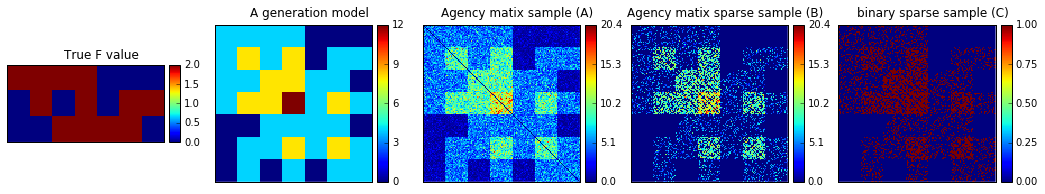

In [6]:
F_true = Fs3[0]
A = gamma_model_test_data(F_true)
power = 0.1
P = np.exp(- power * F_true.T.dot(F_true))
rand = np.random.rand(*A.shape)
mask = P >= ((rand + rand.T) / 2.0)

B = A.copy()
B[mask] = 0
C = B.copy()
C[B != 0] = 1

draw_test_sample(F_true, A, B, C)

## 3.3 Гамма модель

### Случайная инициализация

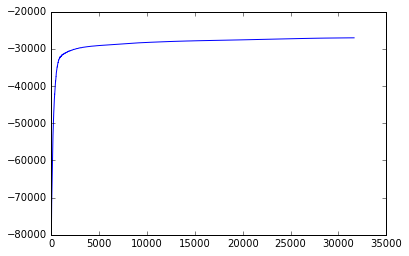

In [4]:
    w_model3r = BigClamGamma(B, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1, processesNo=1)
    F_model3r, LLH3r = w_model3r.fit()
    
    plt.plot(w_model3r.LLH_output_vals)
    w_model73r = BigClamGamma(B, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1, processesNo=1)
    F_model73r, LLH73r = w_model73r.fit()

33179


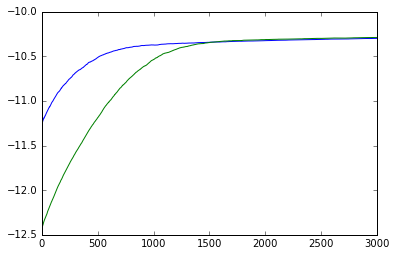

In [5]:
# print len(w_model3r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3r.LLH_output_vals[:3000])))

print len(w_model73r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model73r.LLH_output_vals[:3000])))

In [6]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}\n7 comm LLH:{:.2f}".format(w_model3r.loglikelihood(F_true.T), LLH3r, LLH73r)

True LLH:  -21151.90
3 comm LLH:-27048.21
7 comm LLH:-26046.41


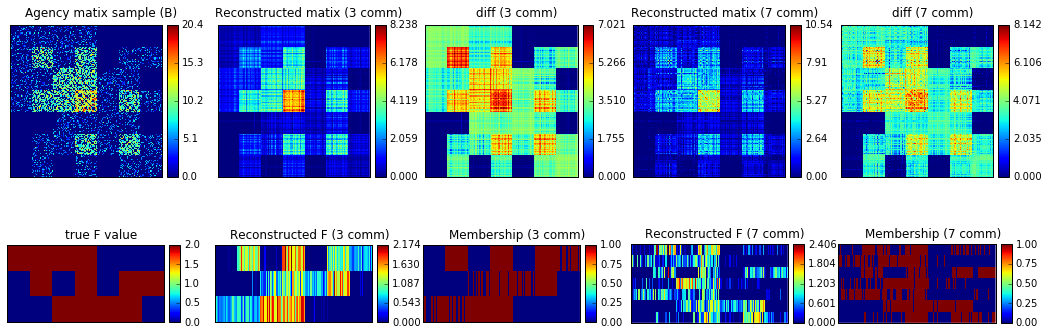

In [7]:
draw_res(B, F_true, F_model3r, F_model73r)

**Вывод:** Для случайного начального приближения ничего не работает.

### Инициализация правильным значением

In [8]:
    w_model3 = BigClamGamma(B, 3, debug_output=False, LLH_output=False, initF=1.0 * F_true.T, iter_output=1, processesNo=1)
    F_model3, LLH3 = w_model3.fit()

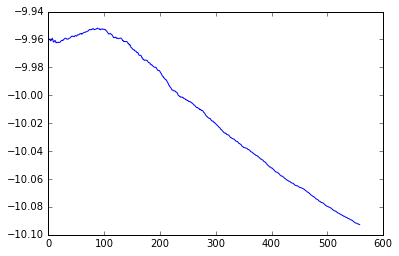

In [9]:
# print len(w_model3.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3.LLH_output_vals[:3000])))

Подогнался под данные

In [10]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}".format(w_model3.loglikelihood(F_true.T), LLH3)

True LLH:  -21151.90
3 comm LLH:-21151.90


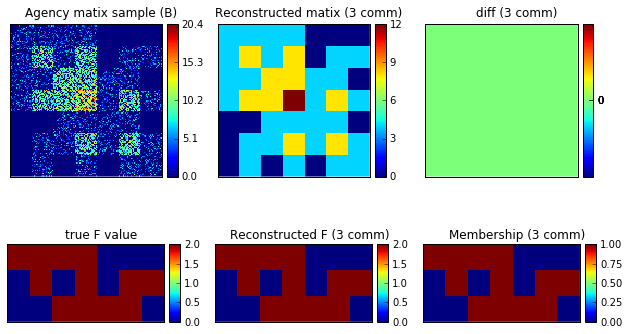

In [11]:
draw_res(B, F_true, F_model3)

**Вывод:** Оптимизационная схема работает правильно

### Инициализация правильным значением с отклонением

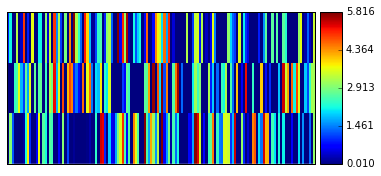

In [12]:
noise_forse = 4
noise = -noise_forse + 2 * noise_forse * np.random.rand(*F_true.T.shape)
init =  1.0 * F_true.T + noise
init[init<0.01] = 0.01    
draw_matrix(init.T)

In [13]:
w_model3 = BigClamGamma(B, 3, debug_output=False, LLH_output=False, initF=init, iter_output=1, processesNo=1)
F_model3, LLH3 = w_model3.fit()

13859


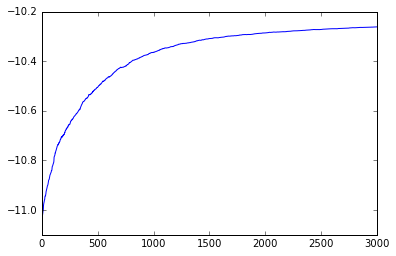

In [14]:
print len(w_model3.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3.LLH_output_vals[:3000])))

In [15]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}".format(w_model3.loglikelihood(F_true.T), LLH3)

True LLH:  -21151.90
3 comm LLH:-27091.98


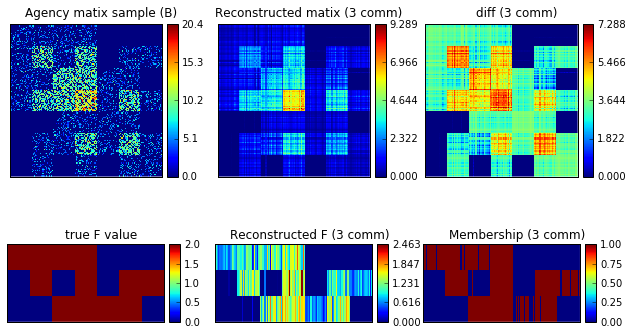

In [16]:
draw_res(B, F_true, F_model3)

### Старт с приближением cond_new_randz_spr

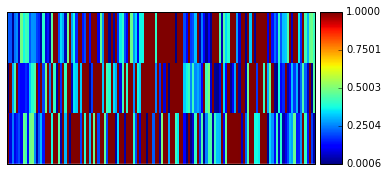

In [17]:
w_model3r = BigClamGamma(B, 3, debug_output=False, LLH_output=False, initF='cond_new_randz', iter_output=1, processesNo=1, rand_init_coef=0.5)
w_model3r.init()
init = w_model3r.initFmode.copy()
# # init = init - 0.3
# init[init<0.75] = 0
# init[init>=0.75] = 1
# init =np.sqrt(init)
draw_matrix(init.T)

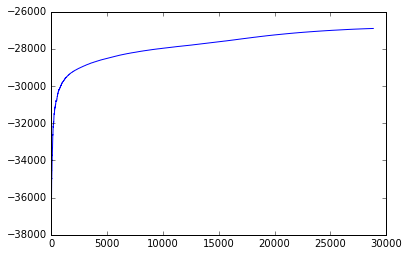

In [18]:
w_model3r = BigClamGamma(B, 3, debug_output=False, LLH_output=False, initF=init, iter_output=1, processesNo=1, rand_init_coef=0.5)
F_model3r, LLH3r = w_model3r.fit()

plt.plot(w_model3r.LLH_output_vals)
w_model73r = BigClamGamma(B, 7, debug_output=False, LLH_output=False, initF=init, iter_output=1, processesNo=1, rand_init_coef=0.5)
F_model73r, LLH73r = w_model73r.fit()

28839


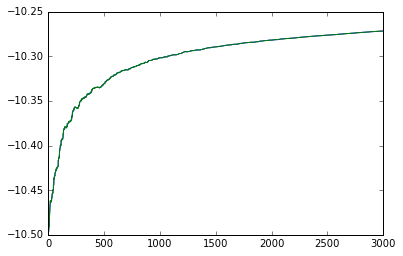

In [19]:
# print len(w_model3r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model3r.LLH_output_vals[:3000])))

print len(w_model73r.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model73r.LLH_output_vals[:3000])))

True LLH:  -21151.90
3 comm LLH:-26906.64
7 comm LLH:-26906.64


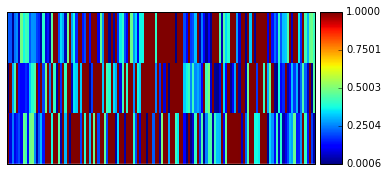

In [20]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}\n7 comm LLH:{:.2f}".format(w_model3r.loglikelihood(F_true.T), LLH3r, LLH73r)
draw_matrix(w_model3r.initFmode.T)

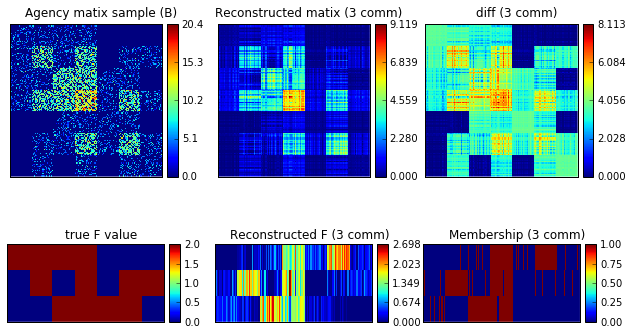

In [21]:
draw_res(B, F_true, F_model3r)

### Общий вывод

* Отличное восстановление из хорошего приближения
* Необходимо придумать хорошее приближение
* Если шум = 2, матрица восстанавливается хуже. Шум = 1.5 еще более менее

## 3.1 BigCLAM (взвешенный вариант)

Основная матрица смежности для работы — B

In [4]:
eps = 1e-4

w_model = BigClam(B, 3, debug_output=False, LLH_output=True, eps=eps)
F_model, LLH = w_model.fit()

w_model7 = BigClam(B, 7, debug_output=False, LLH_output=True, eps=eps)
F_model7, LLH7 = w_model7.fit()

iter: 140, LLH:-89601.4288814
iter: 280, LLH:-71319.9112916
iter: 420, LLH:-32769.6659823
iter: 560, LLH:-32117.7429591
iter: 700, LLH:-28980.1061842
iter: 840, LLH:-28448.4529522
iter: 980, LLH:-28182.4164888
iter: 1120, LLH:-28027.8735423
iter: 1260, LLH:-27998.4910625
iter: 1400, LLH:-27728.6469317
iter: 1540, LLH:-27630.5562132
iter: 1680, LLH:-27567.2627293
iter: 1820, LLH:-27545.9146727
iter: 1960, LLH:-27539.7855517
iter: 2100, LLH:-27509.3477792
iter: 2240, LLH:-27491.7711868
iter: 2380, LLH:-27488.7053698
iter: 2520, LLH:-27473.0473072
iter: 2660, LLH:-27476.9739466
iter: 2800, LLH:-27469.3667884
iter: 140, LLH:-141108.311197
iter: 280, LLH:-92791.7387161
iter: 420, LLH:-42717.8537064
iter: 560, LLH:-37195.033587
iter: 700, LLH:-31765.6569929
iter: 840, LLH:-30560.8765822
iter: 980, LLH:-29744.8207573
iter: 1120, LLH:-28941.1421184
iter: 1260, LLH:-28602.6464646
iter: 1400, LLH:-28122.4707063
iter: 1540, LLH:-28160.8138098
iter: 1680, LLH:-27941.0505432
iter: 1820, LLH:-27759.

In [5]:
print "True LLH:  {:.2f}\n3 comm LLH:{:.2f}\n7 comm LLH:{:.2f}".format(w_model.loglikelihood(F_true.T), LLH, LLH7)

True LLH:  -38787.29
3 comm LLH:-27468.76
7 comm LLH:-27352.37


Наблюдаем, что у истинного F значение правдоподобия намного выше, что не удивительно, ведь модель генерации отличается от модели, которую использует BigClam.
Еще интересно, что при 3 и 7 сообществах значения правдоподобия очень похожи (см. подбор количества сообществ)

**TODO:** Проверить степень правдоподобия, которая достигается на различных значениях *power* 

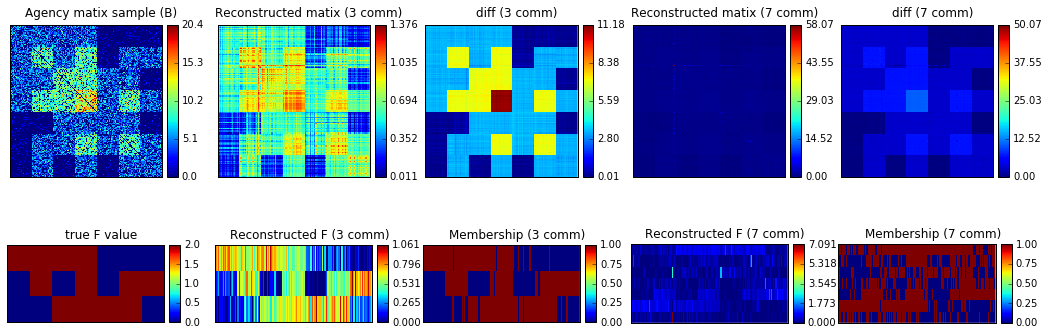

In [6]:
draw_res(B, F_true, F_model, F_model7)

** Интересное наблюдение: ** Если пытаемся восстановить больше сообществ, чем есть (6 график), то получаем сильно коррелированные сообщества. Возможно, так можно подбирать их количество.

## 3.2 BigCLAM (оригинальный вариант)

### Тестирование на не правильной гамма модели

Модель является не правильной, т.к. bigClAM оптимизирует не ее. Значит не стоит расчитывать на восстановление матрицы *F*. Однако, структура сообществ все равно может быть восстановлена, что и будет продемонстрированно.

Рассмотрим несколько вариантов инициализации.

#### Близкая к оптимуму инициализация

Используем только 3 сообщества, т.к. только для этого случая можем взять истинное значение и зашумить его:

In [7]:
noise_forse = 0.2
noise = -noise_forse + 2 * noise_forse * np.random.rand(*F_true.T.shape)
init =  1.0 * F_true.T + noise
init[init < 0] = 0

w_model2 = BigClam(C, 3, debug_output=False, LLH_output=False, initF=init, iter_output=1)
F_model2, LLH2 = w_model2.fit()


1819


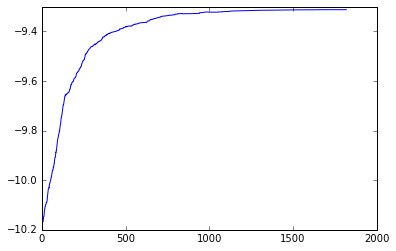

In [8]:
print len(w_model2.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model2.LLH_output_vals[:3000])))

Типичная картина для правдоподобия.

In [9]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}".format(w_model2.loglikelihood(F_true.T), 
                                                                                           np.log(-w_model2.loglikelihood(F_true.T)), 
                                                                                           LLH2, np.log(-LLH2))

True LLH:  -33139.66, 10.41
3 comm LLH:-11074.87, 9.31


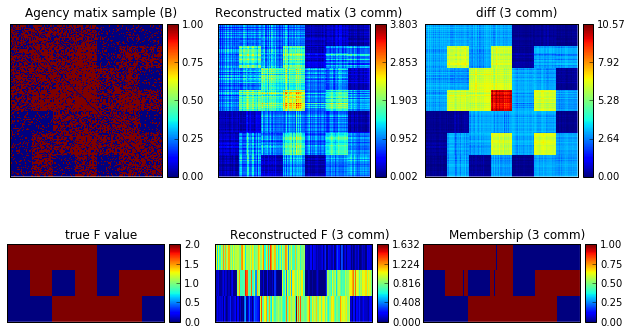

In [10]:
draw_res(C, F_true, F_model2)

#### Вывод

* Матрица А восстанавливается плохо, но это естественно, поскольку модель, которую оптимизирует BigCLAM, не совпадает с моделью генерации.
* Сама структура сообществ восстановлена достаточно хорошо.

#### Случайная инициализация

In [11]:
w_model2r = BigClam(C, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2r, LLH2r = w_model2r.fit()

w_model72r = BigClam(C, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72r, LLH72r = w_model72r.fit()

In [12]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}\n7 comm LLH:{:.2f}, {:.2f}".format(w_model2r.loglikelihood(F_true.T), 
                                                                                               np.log(-w_model2r.loglikelihood(F_true.T)), 
                                                                                               LLH2r, np.log(-LLH2r), LLH72r, np.log(-LLH72r))

True LLH:  -33139.66, 10.41
3 comm LLH:-11129.21, 9.32
7 comm LLH:-10875.43, 9.29


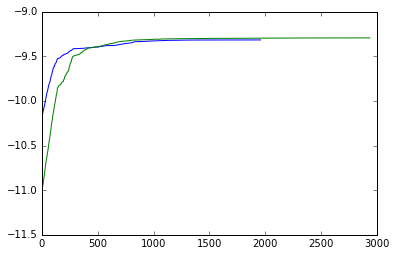

In [13]:
plt.plot(-np.log(-np.array(w_model2r.LLH_output_vals[:3000])), 'b-')
plt.plot(-np.log(-np.array(w_model72r.LLH_output_vals[:3000])), 'g-')

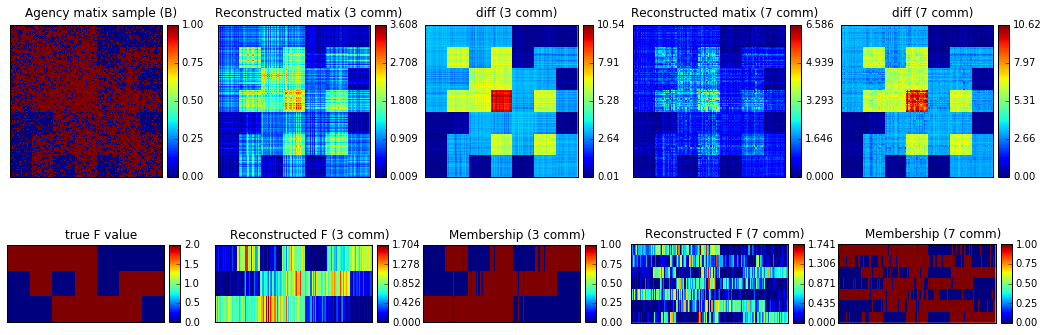

In [14]:
draw_res(C, F_true, F_model2r, F_model72r)

В данном случае, при менее плотной матрице, чем в следующем ниже примере, восстановление происходит достаточно точно. 
В следующем примере все тоже хорошо (плотная матрица А)

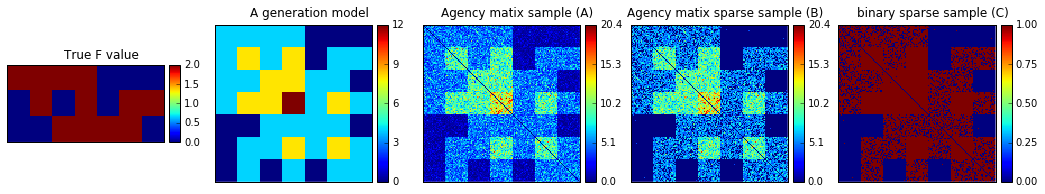

In [18]:
x = np.mean(A) * 0.8
B_bad = A.copy()
B_bad[B_bad < x] = 0
C_bad = B_bad.copy()
C_bad[C_bad >=x] = 1

draw_test_sample(F_true, A, B_bad, C_bad, x)

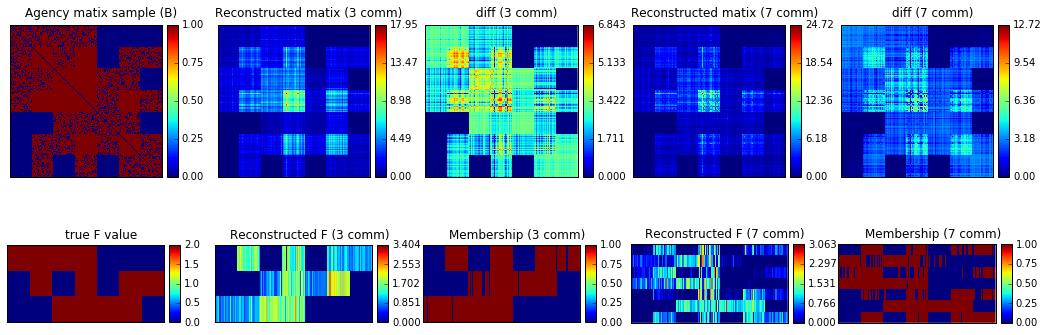

In [19]:
w_model2r_bad = BigClam(C_bad, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2r_bad, LLH2r_bad = w_model2r_bad.fit()

w_model72r_bad = BigClam(C_bad, 7, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72r_bad, LLH72r_bad = w_model72r_bad.fit()

draw_res(C_bad, F_true, F_model2r_bad, F_model72r_bad)

### Общий вывод
Оригинальный BigClam не так чувствителен к начальному приближению, а значит менее устойчив по сравнению с другими методами.
Не всегда это видно на графиках (зависит от *power*), но восстановление происходит не всегда корректно.

### Правильная модель данных для BigCLAM

Рассмотрим более простой пример для оригинального алгоритма

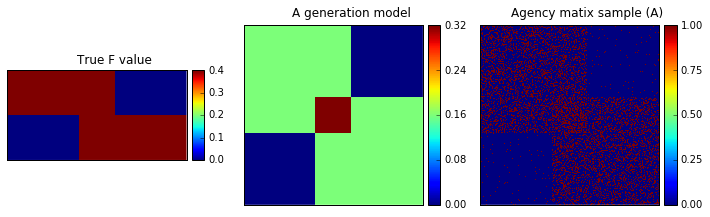

In [20]:
F_true_bc = 0.2 * Fs2[-1]
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

### Случайная инициализация

In [21]:
w_model2_bc = BigClam(B_bc, 2, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model2_bc, LLH2_bc = w_model2_bc.fit()

w_model72_bc = BigClam(B_bc, 3, debug_output=False, LLH_output=False, initF='rand', iter_output=1)
F_model72_bc, LLH72_bc = w_model72_bc.fit()

2599


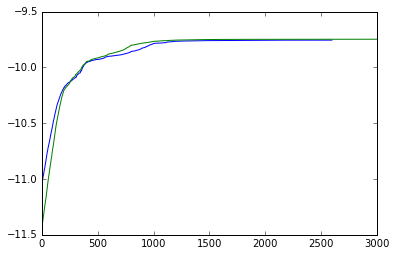

In [22]:
print len(w_model2_bc.LLH_output_vals)
plt.plot(-np.log(-np.array(w_model2_bc.LLH_output_vals[:3000])))
plt.plot(-np.log(-np.array(w_model72_bc.LLH_output_vals[:3000])))

Наблюдаем более адекватное поведедение правдоподобия

In [23]:
print "True LLH:  {:.2f}, {:.2f}\n3 comm LLH:{:.2f}, {:.2f}\n7 comm LLH:{:.2f}, {:.2f}".format(w_model2_bc.loglikelihood(F_true_bc.T), 
                                                                                               np.log(-w_model2_bc.loglikelihood(F_true_bc.T)), 
                                                                                               LLH2_bc, np.log(-LLH2_bc), LLH72_bc, np.log(-LLH72_bc))

True LLH:  -21424.18, 9.97
3 comm LLH:-17253.37, 9.76
7 comm LLH:-17112.95, 9.75


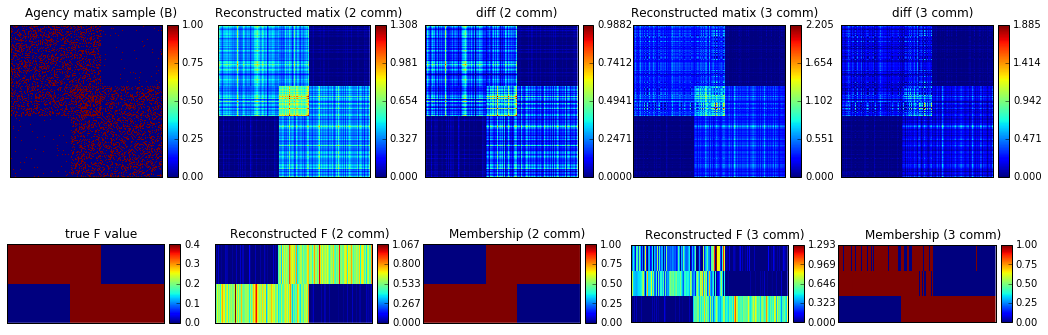

In [24]:
draw_res(B_bc, F_true_bc, F_model2_bc, F_model72_bc)

# 4. Подбор количества сообществ

Было замечено, что при увеличении числа сообществ, логарифм правдоподобия не сильно возрастает после того, как пройдено истинное число сообществ. Проверим этот факт.

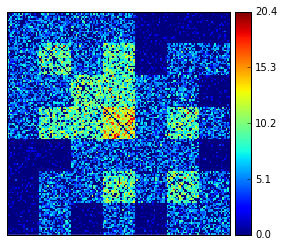

In [6]:
draw_matrix(B)
eps = 1e-2
comm_count = range(1, 10)
init = None
Fs = []
LLHs = []
for i in comm_count:
    bc = BigClam(B, i, initF='cond_new_randz_spr', debug_output=False, LLH_output=False, eps=eps)
    res = bc.fit()
    Fs.append(res[0])
    LLHs.append(res[1])

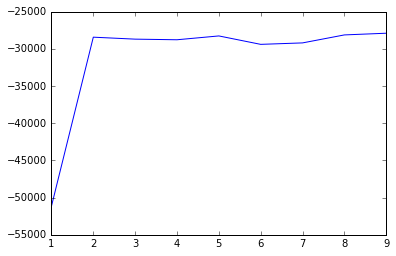

In [7]:
#print '\n'.join("LLH{0}:".format(x)+" {:.2f}" for x in comm_count).format(*LLHs)
plt.plot(comm_count, LLHs)


На модельных данных факт не сильно заметен, хотя прослеживается. Максимум достигается на двух сообществах, хотя на самом деле их 3.

### Проверка на реальных данных

In [54]:
s = 0
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]

DATA_PATH = '../data/weighted/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".gml")]

Fss = []
LLHs = []
comm = range(1, 20, 1)
for ego in ego_paths:
    #D = cPickle.load(file('../data/vk/{}'.format(ego)))
    #G = nx.Graph(D)
    G = nx.read_gml(file(DATA_PATH + '{}'.format(ego)))
    A = np.array(nx.to_numpy_matrix(G))
    Fs = []
    LLH = []
    for k in log_progress(comm):
        bigClam = BigClam(A, k, initF='rand', sparsity_coef=s, LLH_output=False, eps = 1e-2, processesNo=1)
        res = bigClam.fit()
        Fs.append(res[0])
        LLH.append(res[1])
    Fss.append(Fs)
    LLHs.append(LLH)

Ниже продемонстрирован просто способ подбора количества сообществ. Если прирост опускается ниже чем 0.05 от первоначального, то считается, что оптимум по количесву сообществ достигнут. Приведен пример для 4 реальных графов. 

** TODO: ** Проверить как будет работать блочная L1 регуляризация.

3 2


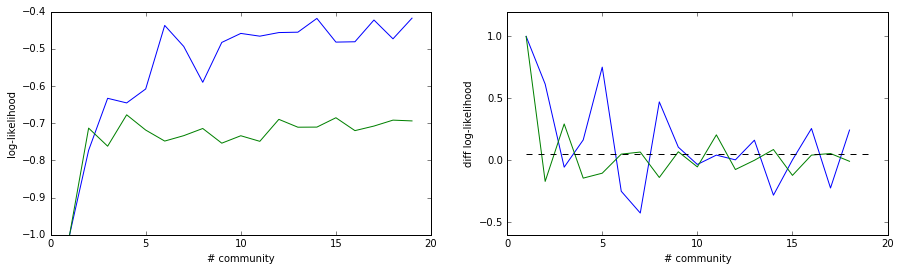

In [63]:
plt.figure(figsize=(15,4))
plt.subplot(121)
LLHs = np.array(LLHs)
plt.plot(comm, - LLHs.T * (1 / LLHs[:,[0]].T))
plt.xlabel("# community")
plt.ylabel("log-likelihood")
plt.subplot(122)
dLLHs = np.diff(LLHs).T
dLLHs = dLLHs / dLLHs[0,:]
for dLLH in dLLHs.T:
    plt.plot(comm[:-1], dLLH)  
plt.xlabel("# community")
plt.ylabel("diff log-likelihood")
bord = 0.05
plt.plot([min(comm), max(comm)],[bord, bord], 'k--')
for dLLH in dLLHs.T:
    print np.nonzero(dLLH < bord)[0][0]+1,
  

Так же вопрос можно изучить со стороны степени коррелированности матрицы F, что было замечено на многочисленных примерах.

In [43]:
def calc_corr(F):
    #print 
    X = np.sum(F, axis=1)
    Fn = F[X!=0,:] * (1 / X[X!=0,None])
    pen = Fn.T.dot(Fn)
    #print pen.shape
    np.fill_diagonal(pen, 0)
    pen = np.sum(pen) / F.shape[1]
    return pen

def calc_dist(F):
    X = spatial.distance.pdist(F.T, metric='cosine')
    return sum(X) / X.shape[0] if X.shape[0] != 0 else 0

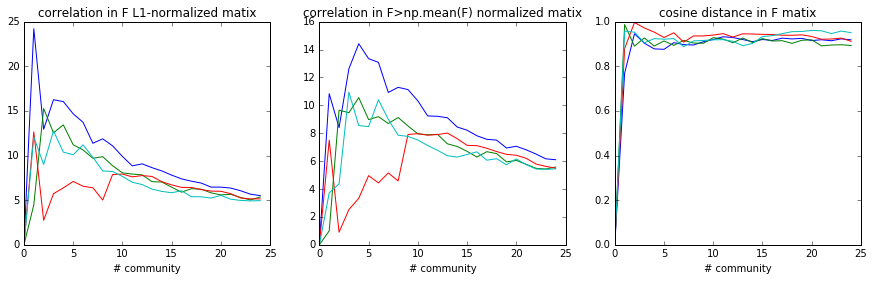

In [44]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(np.array([[calc_corr(F) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("correlation in F L1-normalized matix")
plt.subplot(132)
plt.plot(np.array([[calc_corr(1.0*(F>np.mean(F))) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("correlation in F>np.mean(F) normalized matix")
plt.subplot(133)
plt.plot(np.array([[calc_dist(F) for F in Fs] for Fs in Fss]).T)
plt.xlabel("# community")
plt.title("cosine distance in F matix")

### Выводы
* Метод сломанной трости применим к задаче.
* Интересное поведение у степени коррелированности матрицы F -- с ростом количества сообществ оно падает, что противоречит предположению. (Выводы?)

**TODO:** Проверить на каких-нибудь бенчмарках.

# 5. Зависимость качества оптимизации от размера сообщества

**Задача:** Потестировать качество работы алгоритма в зависимости от размеров модельного графа (кол-ва вершин в каждом сообществе)

In [10]:
def simple_test(size=20, overlapping=10):
    return np.array([[1.0] * size + [0.0] * (size - overlapping), [0.0] * (size-overlapping) + [1.0] * size])

In [29]:
s = 0
LLHs = []
Fss = []
LLHs_true = []
sizes = [5,6,7,8,9, 10,12,14,16,18, 20,30, 40,50,60,70, 100, 150]
overlappings = [0, 0.05, 0.1, 0.2, 0.5, 0.75]
for size in sizes:
    LLH = []
    LLH_true = []
    Fs = []
    for overlapping in overlappings:
        F = 0.5 * simple_test(size, np.floor(overlapping*size))
        A = big_clam_model_test_data(F)
        #draw_test_sample(F, A)
        bigClam = BigClam(A, 2, sparsity_coef=s, LLH_output=False)
        res = bigClam.fit()
        Fs.append(res[0])
        LLH.append(res[1])
        LLH_true.append(bigClam.loglikelihood(F.T))
        print ".",
    Fss.append(Fs)
    LLHs.append(LLH)
    LLHs_true.append(LLH_true)
    print "."

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .


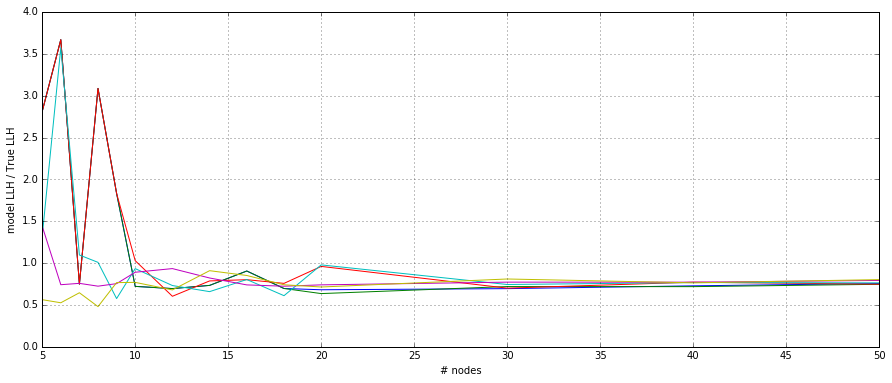

In [40]:
plt.figure(figsize=(15,6))
plt.plot(sizes, np.array(LLHs) / np.array(LLHs_true), label=["0", "0.05", "0.1", "0.2", "0.5", "0.75"])
plt.xlim([5,50])
plt.grid()
plt.xlabel("# nodes")
plt.ylabel("model LLH / True LLH")

Видно, что до некоророго момента (<10 вершин) модель переобучается.
После 10 выходит на некоторый постоянный уровень провдоподобия (75-80% от истинного)

# 6. Регуляризация для декорреляции матрицы F

**Проблема:** Часто метод выдает сообщества, которые имеют значительные пересечения между собой. Хочется избавится от этой особенности. Для избавления будем добавлять следующий регуляризатор:

$$
Pen = -\alpha \sum_{i\ne j}F_i^T F_j.
$$

Протестируем поведение коррелированности в зависимости от коэффициента $ \alpha $. Построим график зависимости $ Pen/\alpha $ от $\alpha$.
Проведем эксперимент на реальных данных для трех случаев: малого числа сообществ (2), оптимального (4), и большого (8)

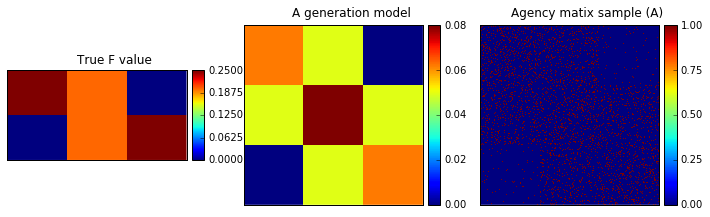

In [8]:
test_size = 32
F_true_bc = 0.5 * np.array([[0.5] * 2 * test_size + [0.4] * test_size + [0.4] * test_size + [0] * 2 * test_size, 
                            [0] * 2 * test_size + [0.4] * test_size + [0.4] * test_size + [0.5] * 2 * test_size])
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

In [9]:
K = 2
sparsity_coefs = xrange(1,100)
init = None

Fs = []
Fs_init = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='cond_new' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1, stepSizeMod="simple")
    Fs.append(bigClam.fit())
    Fs_init.append(bigClam.initFmode)
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

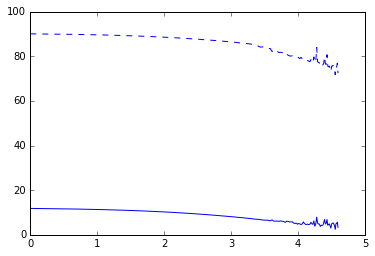

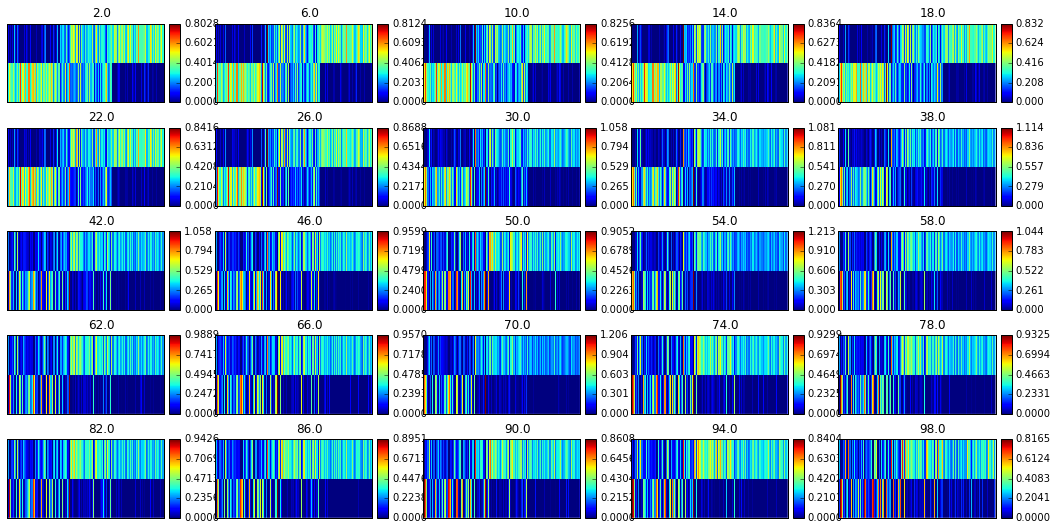

In [10]:
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')
plt.figure(figsize=(18, 9))
for i,j in enumerate(xrange(1, 100, 4)):
    plt.subplot(5, 5, i+1)
    draw_matrix(Fs[j][0].T, np.floor(100* sparsity_coefs[j]) / 100)

Первое, что бросается в глаза -- неустойчивое поведение правдоподобия. Там, где значение достигает нуля, обычно матрица F просто нулевая (локальный минимум). Возможно, это можно поправить, если отделяться от нуля небольшим значением. Без этого видим, что оптимизационная процедура сваливаеся в 0.

In [19]:
K = 3
sparsity_coefs = np.linspace(1, 1000, 200)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1, stepSizeMod="simple")
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

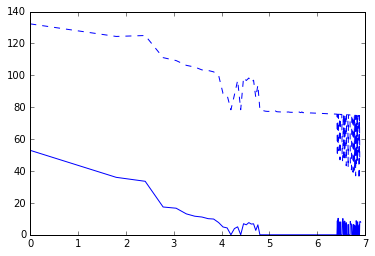

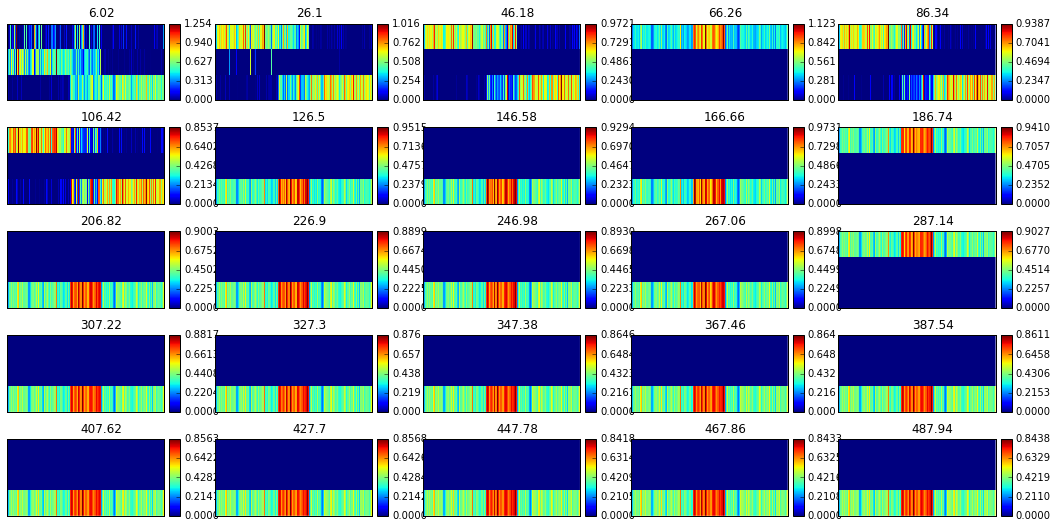

In [20]:
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')

plt.figure(figsize=(18, 9))
for i,j in enumerate(xrange(1, 100, 4)):
    plt.subplot(5, 5, i+1)
    draw_matrix(Fs[j][0].T, np.floor(100* sparsity_coefs[j]) / 100)

In [ ]:
K = 2
sparsity_coefs = np.linspace(1, 500, 100)
init = None

Fs = []
pen = []
for s in log_progress(sparsity_coefs):
    bigClam = BigClam(B_bc, K, sparsity_coef=s, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-4, alpha=0.1, stepSizeMod="simple")
    Fs.append(bigClam.fit())
    pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
    if init is None:
        init = bigClam.initFmode.copy()

plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen), 'b')
plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]), 'b--')

In [13]:
    K = 4
    import os
    DATA_PATH = '../data/vk/'
    ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
    Fss = []
    pens = []
    #sparsity_coefs = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
    sparsity_coefs = [0.001, 0.01, 0.1, 1, 10, 100, 200]
    for ego in ego_paths:
        D = cPickle.load(file('../data/vk/{}'.format(ego)))
        G = nx.Graph(D)
        A = np.array(nx.to_numpy_matrix(G))
        Fs = []
        pen = []
        init = None
        for s in log_progress(sparsity_coefs):
            bigClam = BigClam(A, K, sparsity_coef=s, initF='rand', debug_output=False, LLH_output=False, stepSizeMod="simple")
            Fs.append(bigClam.fit())
            pen.append(bigClam.calc_penalty(Fs[-1][0], real=True))
            if init is None:
                init = bigClam.initFmode.copy()
        Fss.append(Fs)
        pens.append(pen)

Рассмотрим аналогичный пример на реальных данных, посмотрим на матрицу F в зависимости от коэффициента:

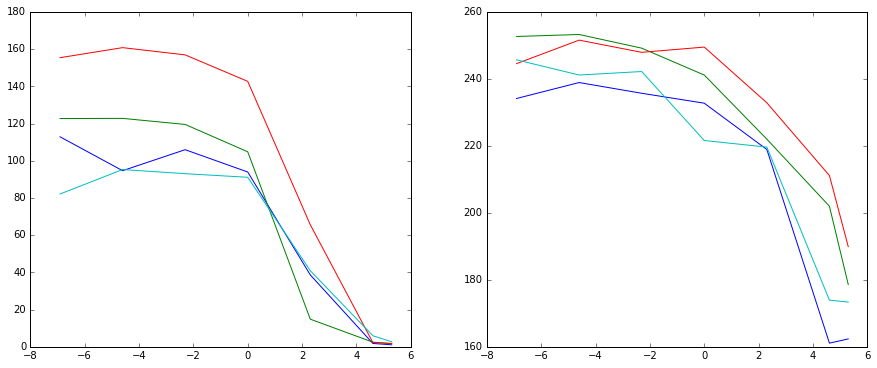

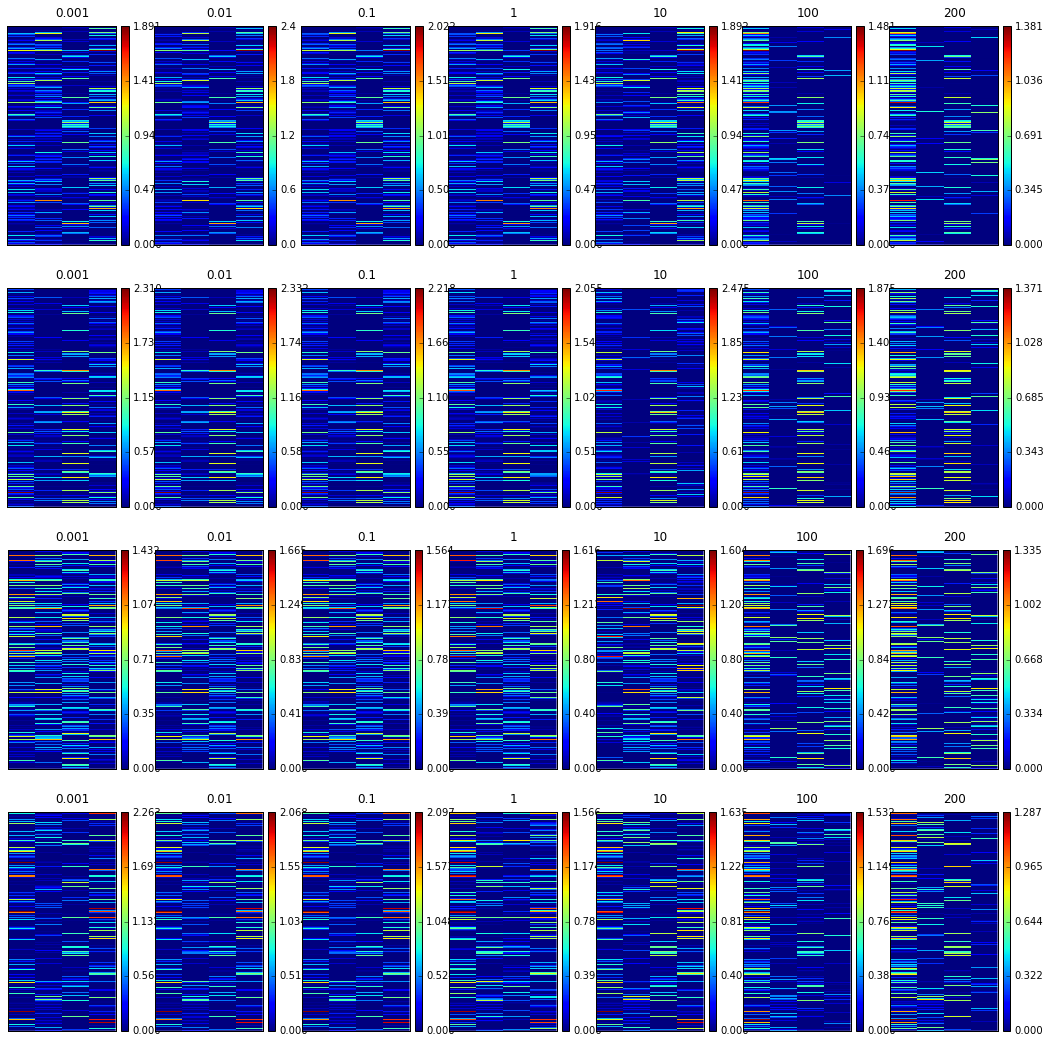

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(121)
for pen in pens:
    plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array(pen))
plt.subplot(122)
for Fs in Fss:
    plt.plot(np.log(0.000001 + np.array(sparsity_coefs)), np.array([np.sum(np.abs(F[0])) for F in Fs]))

plt.figure(figsize=(18,18))
for i, Fs in enumerate(Fss):
    for j, F in enumerate(Fs):
        plt.subplot(len(ego_paths), len(sparsity_coefs), j+i*len(Fs)+1)
        draw_matrix(F[0], sparsity_coefs[j])

Видна похожая тенденция при больших значениях штрафа -- в матрице F зануляется часть сообществ, возможно, это можно использовать для поддобра количества сообществ в графе, не ясно как подбирать величину штрафа.

Отделим значение F от нуля значением 0.01 и проведем такой же эксперимент для модельных данных

# 7. Зависимость качества оптимизации от параметра alpha

Параметр из процедуры подбора шага *backtrakingLineSearch*.

Будем проверять на самом простом примере с 2 сообществами и на реальных данных

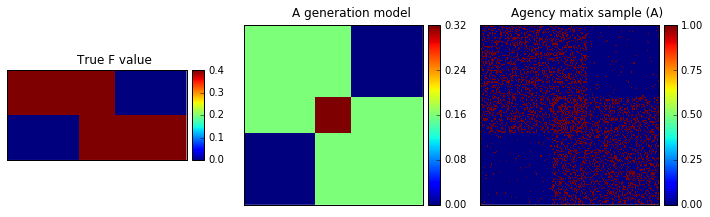

In [15]:
test_size = 8
F_true_bc = 0.4 * np.array([[1] * 12 * test_size + [0] * 8 * test_size, [0] * 8 * test_size + [1] * 12 * test_size])
B_bc = big_clam_model_test_data(F_true_bc)
draw_test_sample(F_true_bc, B_bc)

In [16]:
K = 2
init = None

Fs = []
itersLLH = []
alphas = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
for alpha in log_progress(alphas):
    bigClam = BigClam(B_bc, K, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-2, alpha=alpha, iter_output=1)
    res = bigClam.fit()
    Fs.append(res[0])
    itersLLH.append(bigClam.LLH_output_vals)
    if init is None:
        init = bigClam.initFmode.copy()
        
bigClam = BigClam(B_bc, K, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-2, alpha=alpha, iter_output=1, stepSizeMod="simple")
res = bigClam.fit()
Fs.append(res[0])
itersLLH.append(bigClam.LLH_output_vals)
if init is None:
    init = bigClam.initFmode.copy()
    
alphas.append(-1)

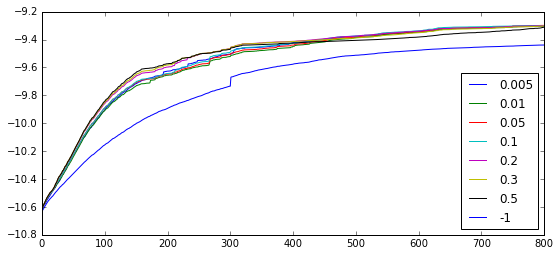

In [17]:
plt.figure(figsize=(9,4))
for llh, alpha in zip(itersLLH, alphas):
    plt.plot(-np.log(-np.array(llh[:800])), label=str(alpha))
plt.legend(loc=4)

На маленьком тестовом примере значение alpha почти ни на что не влияет.

Посмотрим на реальных данных.

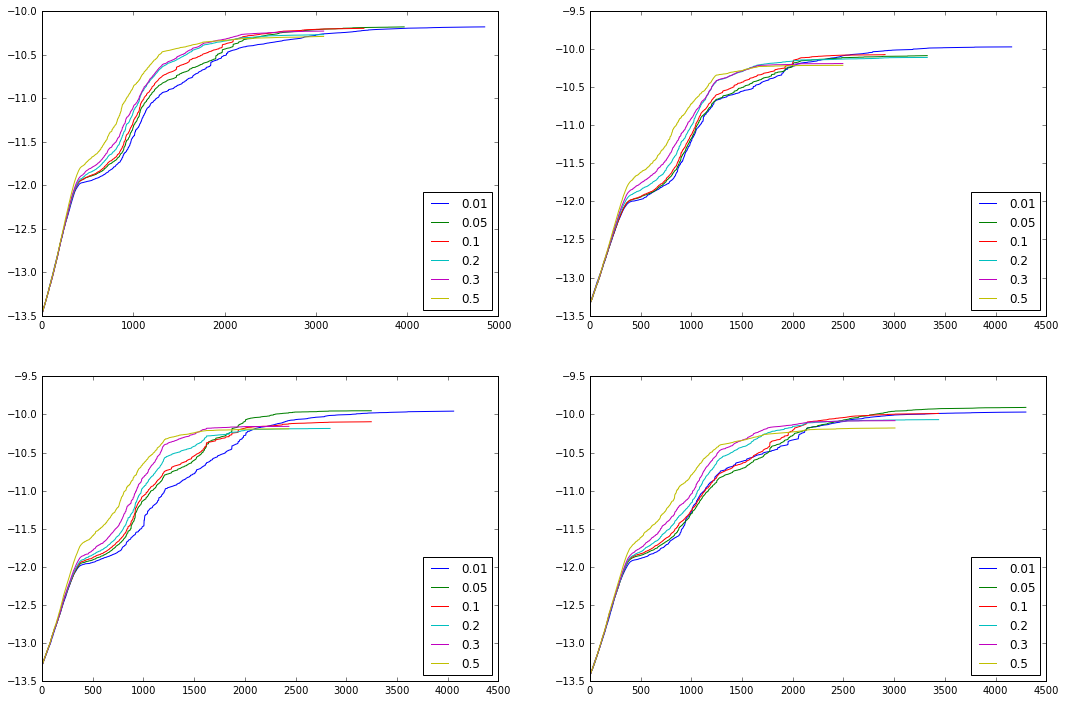

In [96]:
K = 4
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]

alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
plt.figure(figsize=(18,12))
for indx, ego in enumerate(ego_paths):
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    init = None
    Fs = []
    itersLLH = []
    for alpha in log_progress(alphas):
        bigClam = BigClam(A, K, initF='rand' if init is None else init, debug_output=False, LLH_output=False, eps=1e-2, alpha=alpha, iter_output=1)
        res = bigClam.fit()
        Fs.append(res[0])
        itersLLH.append(bigClam.LLH_output_vals)
        if init is None:
            init = bigClam.initFmode.copy()
    plt.subplot(2,2,indx+1)
    for llh, alpha in zip(itersLLH, alphas):
        plt.plot(-np.log(-np.array(llh)), label=str(alpha))
    plt.legend(loc=4)